# Inspect COCO dataset

In [1]:
from pycocotools.coco import COCO
import random
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import defaultdict
import cv2
import sys
sys.path.append("3d_rendering")
from fridge_dataset.config import get_cfg_defaults, setup_cfg
import pandas as pd
from plotutils import get_params, set_style, to_defaults, tex_escape, save_fig, gen_img_grid, cmap, colors, cmap, title_case
import seaborn as sns
from grcore.img import maskutils
from grcore.img.file_io import load_img
from grcore.coco.utils import extract_imgids
from grcore.coco.dataset import CocoDataset
from fridgecore.coco.occ import is_whole, get_cat_name
import numpy as np
from cycler import cycler

In [2]:
whole_path = "/data/dataset/fridge/coco_parts_ts4/annotations/train_wholes.json"
part_path = "/data/dataset/fridge/coco_parts_ts4/annotations/train_parts.json"
dset = CocoDataset(whole_path, part_path, from_gt=True)



loading annotations into memory...
Loading json: /data/dataset/fridge/coco_parts_ts4/annotations/train_wholes.json
Done 2.88s
creating index...
index created!
loading annotations into memory...
Loading json: /data/dataset/fridge/coco_parts_ts4/annotations/train_parts.json
Done 4.50s
creating index...
index created!


In [5]:
# Coco attributes
print(f"cat: {dset.cats[1].keys()}")
print(f"whole ann: {dset.load_anninfos([1], from_gt=True)[0].keys()}")
print(f"part ann: {dset.load_anninfos([1], from_gt=False)[0].keys()}")
print(f"whole img: {dset.load_imginfos([1], from_gt=True)[0].keys()}")
print(f"whole img: {dset.load_imginfos([1], from_gt=False)[0].keys()}")

cat: dict_keys(['id', 'name', 'supercategory'])
whole ann: dict_keys(['id', 'image_id', 'category_id', 'segmentation', 'area', 'bbox', 'iscrowd', 'is_occluded', 'occluders', 'spawn_id'])
part ann: dict_keys(['id', 'image_id', 'category_id', 'segmentation', 'area', 'bbox', 'iscrowd', 'is_occluded', 'occluders', 'spawn_id'])
whole img: dict_keys(['id', 'width', 'height', 'file_name', 'license', 'flickr_url', 'coco_url', 'date_captured', 'bimg_id', 'occupancy', 'iou'])
whole img: dict_keys(['id', 'width', 'height', 'file_name', 'license', 'flickr_url', 'coco_url', 'date_captured', 'bimg_id', 'occupancy', 'iou'])


## Config

In [2]:
cfg = get_cfg_defaults()
cfg.merge_from_file("/data/gregork/workspace/robot-simulation/configs/dataset/ts4_train.yaml")
setup_cfg(cfg)
cfg.freeze()
print(cfg)

AUG:
  MISS:
    COUNT: 300
    PATH: miss.aug
    TYPE: train
  RUN: True
  TEST:
    COUNT: 1200
    PATH: /home/gregork/workspace/robot-simulation/data/test_ts4.aug
    TYPE: test
  TRAIN:
    COUNT: 9000
    PATH: /home/gregork/workspace/robot-simulation/data/train_ts4.aug
    TYPE: train
  VAL:
    COUNT: 400
    PATH: /home/gregork/workspace/robot-simulation/data/val_ts4.aug
    TYPE: train
BATCH:
  MISS: 56
  TEST: 1
  TRAIN: 3
  VAL: 1
DATASET:
  IMG_EXT: jpg
  PATH: /home/gregork/dataset/coco_parts_ts4
  SETS: ('train',)
  SPLIT:
    FRACTION: 0.2
    PATH: /home/gregork/workspace/robot-simulation/data/data_split_ts4.json
    SET: test
  TYPE: coco
DB:
  PATH: /home/gregork/workspace/robot-simulation/out/blender/no_occ2/data.h5
EXP:
  CAPS: [10, 20, 30, 50, 70]
  SAVE_IMGS: True
OUTPUT:
  PATH: /home/gregork/workspace/robot-simulation/out/dataset/ts4
PARTS:
  CATS_PATH: /home/gregork/workspace/robot-simulation/configs/blender/part_cats.json
  CAT_CORRECTIONS_PATH: /home/gregor

In [3]:
# Define paths
base_path = Path(cfg.DATASET.PATH)
jsons = {
        "train":{"wholes":"train_wholes.json", "parts": "train_parts.json"},   
        "test":{"wholes": "test_wholes.json","parts": "test_parts.json"},
        "val":{"wholes": "val_wholes.json","parts": "val_parts.json"},
}

img_paths = {
        "train": base_path / "train",
        "test": base_path / "test",
        "val": base_path / "val"
}

## Load 

In [4]:
cocos = defaultdict(dict)
for ttv, ttv_val in jsons.items():
        for type_, value in ttv_val.items():
                cocos[ttv][type_] = COCO(str(base_path / "annotations" / value))

loading annotations into memory...
Done (t=1.61s)
creating index...
index created!
loading annotations into memory...
Done (t=2.71s)
creating index...
index created!
loading annotations into memory...
Done (t=16.66s)
creating index...
index created!
loading annotations into memory...
Done (t=16.35s)
creating index...
index created!
loading annotations into memory...
Done (t=6.93s)
creating index...
index created!
loading annotations into memory...
Done (t=4.58s)
creating index...
index created!


## Image count

In [5]:
for ttv, ttv_val in cocos.items():
    for type_, coco in ttv_val.items():
        # Dataset type
        print(f"{ttv}/{type_}: {len(coco.getImgIds())}")       

train/wholes: 9168
train/parts: 9168
test/wholes: 6400
test/parts: 6400
val/wholes: 2000
val/parts: 2000


## Check categories in sync

In [6]:
orig_cats = dict()
orig_saved = False
for ttv, ttv_val in cocos.items():
    for type_, coco in ttv_val.items():
        
        # Print categories
        cat_ids = coco.getCatIds()
        cats = coco.loadCats(cat_ids)
        
        if not orig_saved:
            orig_cats = cats
            orig_saved = True

        if orig_cats == cats:
            print(f"{ttv}/{type_}: OK")
        else:
            print(f"{ttv}/{type_}: FAIL")

df = pd.DataFrame.from_dict(orig_cats)
print(df)


train/wholes: OK
train/parts: OK
test/wholes: OK
test/parts: OK
val/wholes: OK
val/parts: OK
    id            name   supercategory
0    1    bottle_water    bottle_water
1    2           bread           bread
2    3        broccoli        broccoli
3    4          butter          butter
4    5         cabbage         cabbage
5    6          carrot          carrot
6    7          cheese          cheese
7    8          chilli          chilli
8    9            coke            coke
9   10       courgette       courgette
10  11  cream_whipping  cream_whipping
11  12        cucumber        cucumber
12  13            eggs            eggs
13  14   extract_yeast   extract_yeast
14  15     food_canned     food_canned
15  16          garlic          garlic
16  17           jelly           jelly
17  18          bottom           jelly
18  19             cap           jelly
19  20           label           jelly
20  21             top           jelly
21  22           juice           juice
22  23    

## Check ids > 0 | <= len(ids)

In [7]:
for ttv, ttv_val in cocos.items():
    for type_, coco in ttv_val.items():
        errors = []
        imgids = coco.getImgIds()
        minid = min(imgids)
        maxid = max(imgids)
        truemax = len(imgids)
        if minid < 1 or maxid != truemax:
            errors.append(f"Invalid IMAGE IDs: min\t{minid}/{1}\tmax\t{maxid}/{truemax}")
        catids = coco.getCatIds()
        minid = min(catids)
        maxid = max(catids)
        truemax = len(catids)
        if minid < 1 or maxid != truemax:
            errors.append(f"Invalid CAT IDs: min\t{minid}/{1}\tmax\t{maxid}/{truemax}")
        annids = coco.getAnnIds()
        minid = min(annids)
        maxid = max(annids)
        truemax = len(annids)
        if minid < 1 or maxid != truemax:
            errors.append(f"Invalid ANN IDs: min\t{minid}/{1}\tmax\t{maxid}/{truemax}")
        if errors:
            print(f"{ttv}/{type_}: FAIL")
            for error in errors:
                print(error)
        else:
            print(f"{ttv}/{type_}: OK")

train/wholes: OK
train/parts: OK
test/wholes: OK
test/parts: OK
val/wholes: OK
val/parts: OK


## Check juice and bottle juice categories

In [8]:
for ttv, ttv_val in cocos.items():
    for type_, coco in ttv_val.items():
        print(f"{ttv}/{type_}")
        catid = 25 # bottle_juice
        annids = coco.getAnnIds(catIds=[catid])
        print(f"bottle juice: {len(annids)} instances")
        catid = 22 # juice/juice
        annids = coco.getAnnIds(catIds=[catid])
        print(f"juice/juice: {len(annids)} instances")



train/wholes
bottle juice: 744 instances
juice/juice: 4686 instances
train/parts
bottle juice: 744 instances
juice/juice: 0 instances
test/wholes
bottle juice: 9360 instances
juice/juice: 3920 instances
test/parts
bottle juice: 9360 instances
juice/juice: 0 instances
val/wholes
bottle juice: 3020 instances
juice/juice: 1095 instances
val/parts
bottle juice: 3020 instances
juice/juice: 0 instances


## Print random annotations

for ttv, ttv_val in cocos.items():
    for type_, coco in ttv_val.items():
        print(f"{ttv}/{type_}")
        # Check unique annotation ids
        ann_ids = coco.getAnnIds()
        ann_id = random.choice(ann_ids)
        ann_info = coco.loadAnns([ann_id])[0]
        print(ann_info)

## Print random images

for ttv, ttv_val in cocos.items():
    for type_, coco in ttv_val.items():
        img_ids = coco.getImgIds()
        img_id = random.choice(img_ids)
        img_info = coco.loadImgs([img_id])
        print(f"{ttv}/{type_}")
        print(img_info)

## Show random images

Loading img: /home/gregork/dataset/coco_parts_ts4/train/img_884.jpg
train/wholes


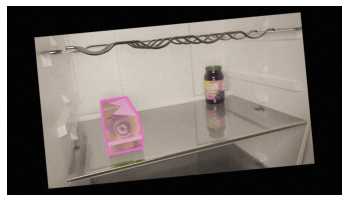

Loading img: /home/gregork/dataset/coco_parts_ts4/train/img_876.jpg
train/parts


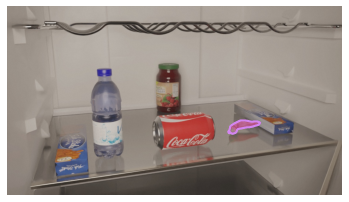

Loading img: /home/gregork/dataset/coco_parts_ts4/test/img_2414.jpg
test/wholes


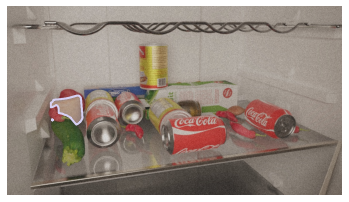

Loading img: /home/gregork/dataset/coco_parts_ts4/test/img_2182.jpg
test/parts


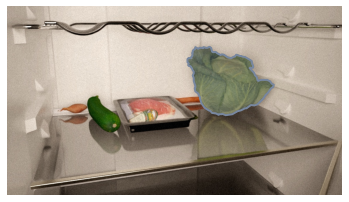

Loading img: /home/gregork/dataset/coco_parts_ts4/val/img_1707.jpg
val/wholes


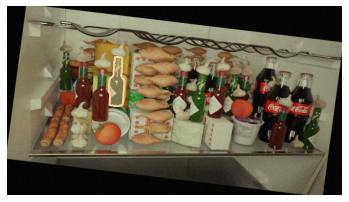

Loading img: /home/gregork/dataset/coco_parts_ts4/val/img_1356.jpg
val/parts


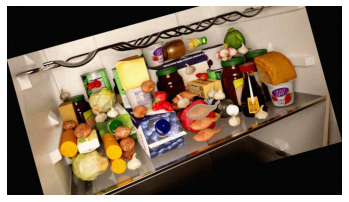

In [9]:
# Show random images
for ttv, ttv_val in cocos.items():
    for type_, coco in ttv_val.items():
        # Random image
        img_ids = coco.getImgIds()
        img_id = random.choice(img_ids)
        img_info = coco.loadImgs([img_id])[0]
        img_path = str( img_paths[ttv] / img_info["file_name"])
        img = load_img(img_path)

        # Random annotation
        ann_ids = coco.getAnnIds(imgIds=[img_id])
        ann_ids = random.choice(ann_ids)
        ann = coco.loadAnns(ann_ids)

        print(f"{ttv}/{type_}")
        plt.figure()
        plt.imshow(img); plt.axis("off")
        coco.showAnns(ann)
        

        path = str(Path(f"{ttv}_{type_}_example"))
        #plt.savefig(path)
        plt.show()

## Show Random GT and DT

Loading img: /home/gregork/dataset/coco_parts_ts4/train/img_7931.jpg


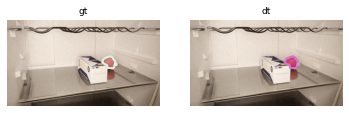

Loading img: /home/gregork/dataset/coco_parts_ts4/test/img_553.jpg


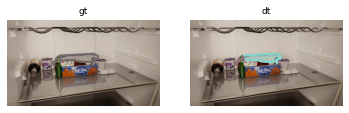

Loading img: /home/gregork/dataset/coco_parts_ts4/val/img_1280.jpg


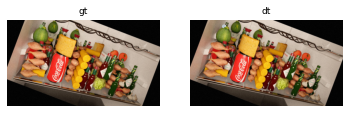

In [10]:
for ttv, ttv_val in cocos.items():
    coco = ttv_val["wholes"]
    # Random image
    img_ids = coco.getImgIds()
    img_id = random.choice(img_ids)
    img_info = coco.loadImgs([img_id])[0]
    img_path = str( img_paths[ttv] / img_info["file_name"])
    img = load_img(img_path)

    # Random annotation
    ann_ids = coco.getAnnIds(imgIds=[img_id])
    ann_id = random.choice(ann_ids)
    ann = coco.loadAnns([ann_id])[0]
    spawn_id = ann["spawn_id"]

    # Get DT annotation
    coco_dt = ttv_val["parts"]
    ann_ids = coco_dt.getAnnIds(imgIds=[img_id])
    anns = coco_dt.loadAnns(ann_ids)
    ann_dts = [ann for ann in anns if ann["spawn_id"] == spawn_id]
    
    
    # Show images
    plt.figure()
    plt.subplot(1,2,1)
    plt.title("gt", fontsize=9)
    plt.imshow(img); plt.axis("off")
    coco.showAnns([ann])
    plt.subplot(1,2,2)
    plt.title("dt", fontsize=9)
    plt.imshow(img); plt.axis("off")
    coco_dt.showAnns(ann_dts)
    plt.show()

## IOU distribution

to_defaults()
params = get_params("pdf")
set_style("notebook", "darkgrid", params)

data = dict()
for ttv, ttv_val in cocos.items():
    data[ttv] = {"iou":[], "occ":[]}
    coco = ttv_val["wholes"]

    img_ids = coco.getImgIds()
    img_infos = coco.loadImgs(img_ids)
    for img_info in img_infos:
        data[ttv]["iou"].append(img_info["iou"])
        data[ttv]["occ"].append(img_info["occupancy"])
df = pd.DataFrame.from_dict(data)

plt.figure()
sns.distplot(df.loc["iou","train"], kde=False)
plt.title("IOU distribution over train images")
plt.xlabel("IOU")
plt.ylabel("Freq")
plt.show()

plt.figure()
sns.distplot(df.loc["iou","val"], kde=False)
plt.title("IOU distribution over val images")
plt.xlabel("IOU")
plt.ylabel("Freq")
plt.show()

plt.figure()
sns.distplot(df.loc["iou","test"], kde=False)
plt.title("IOU distribution over test images")
plt.xlabel("IOU")
plt.ylabel("Freq")
plt.show()

## OCC distribution

In [11]:
# Get data
data = dict()
for ttv, ttv_val in cocos.items():
    data[ttv] = {"iou":[], "occ":[]}
    coco = ttv_val["wholes"]

    img_ids = coco.getImgIds()
    img_infos = coco.loadImgs(img_ids)
    for img_info in img_infos:
        data[ttv]["iou"].append(img_info["iou"])
        data[ttv]["occ"].append(img_info["occupancy"])
df = pd.DataFrame.from_dict(data)

Saving fig: /data/gregork/workspace/robot-simulation/out/dataset/ts4/occ_train


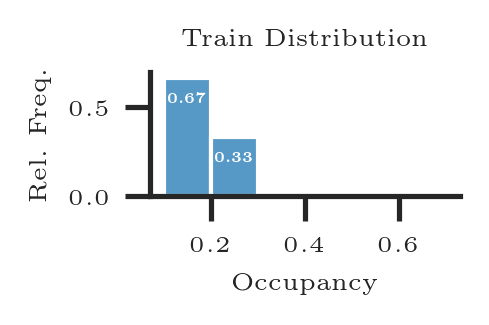

Saving fig: /data/gregork/workspace/robot-simulation/out/dataset/ts4/occ_val


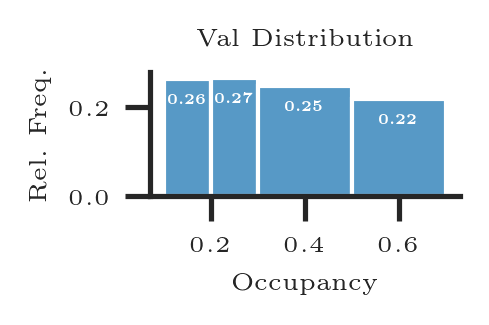

Saving fig: /data/gregork/workspace/robot-simulation/out/dataset/ts4/occ_test


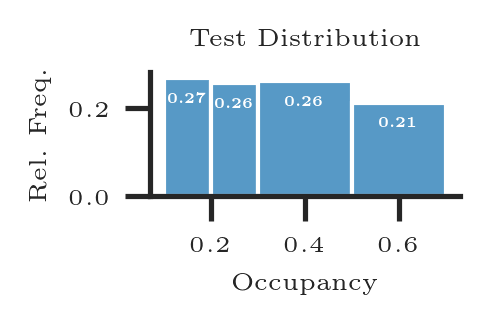

In [12]:
# Define plotting parameters
to_defaults()
params = get_params("pdf", 103.50105, "pt", ar="golden", f="lm", fs=6, ff="serif", show_dpi=300)
set_style("notebook", "ticks", params)
bins = [0.1,0.2,0.3,0.5,0.7]

def add_height_text(ax, ):
    clr = "white"
    for patch in ax.patches:
        w = patch.get_width()
        h = patch.get_height()
        x,y = patch.get_xy()
        if h > 0.0:
            ax.annotate(rf"\textbf{{ {{{h:.2f}}} }}", xy=(x+w/2, h), xytext=(0,-5), textcoords="offset points", ha="center", va="center", color=clr, clip_on=True, fontsize="xx-small")

# Plot figures
fig = plt.figure()
#fig.set_tight_layout(False)
sns.histplot(df.loc["occ", "train"], bins=bins, stat="probability", ax=plt.gca())
#ax = df.loc["occ", "train"].plot(kind="bar", ax=plt.gca(), rot=0)
plt.title("Train Distribution")
plt.xlabel("Occupancy")
plt.ylabel("Rel. Freq.")

# Add percentages to each rectangle
add_height_text(plt.gca())

sns.despine()
save_fig(fig, Path(cfg.OUTPUT.PATH) / "occ_train")
plt.show()

fig = plt.figure()
sns.histplot(df.loc["occ", "val"], bins=bins, stat="probability", ax=plt.gca())
plt.title("Val Distribution")
plt.xlabel("Occupancy")
plt.ylabel("Rel. Freq.")

# Add percentages to each rectangle
add_height_text(plt.gca())

sns.despine()
save_fig(plt.gcf(), Path(cfg.OUTPUT.PATH) / "occ_val")
plt.show()

fig = plt.figure()
sns.histplot(df.loc["occ", "test"], bins=bins, stat="probability", ax=plt.gca())
plt.title("Test Distribution")
plt.xlabel("Occupancy")
plt.ylabel("Rel. Freq.")

# Add percentages to each rectangle
add_height_text(plt.gca())

sns.despine()
save_fig(plt.gcf(), Path(cfg.OUTPUT.PATH) / "occ_test")
plt.show()

## IOU OCC correlation

plt.figure()
sns.scatterplot(x=df.loc["occ", "train"], y=df.loc["iou", "train"])
plt.title("OCC IOU correlation")
plt.xlabel("OCC")
plt.ylabel("IOU")
plt.show()

plt.figure()
sns.scatterplot(x=df.loc["occ", "val"], y=df.loc["iou", "val"])
plt.title("OCC IOU correlation")
plt.xlabel("OCC")
plt.ylabel("IOU")
plt.show()

plt.figure()
sns.scatterplot(x=df.loc["occ", "test"], y=df.loc["iou", "test"])
plt.title("OCC IOU correlation")
plt.xlabel("OCC")
plt.ylabel("IOU")
plt.show()

## Class distribution

In [23]:
# Create list of categories for each annotation
data = defaultdict(list)
for ttv, ttv_val in cocos.items():
    coco_gt = ttv_val["wholes"]
    coco_dt = ttv_val["parts"]
    data[ttv] = {"catid":[], "cat":[], "supercat":[]}
    
    catids = [17, 18, 19, 20, 21, 22, 23, 24, 31, 32, 33]
    gt_ann_ids = coco_gt.getAnnIds(catIds=catids)
    gt_ann_infos = coco_gt.loadAnns(gt_ann_ids)
    dt_ann_ids = coco_dt.getAnnIds(catIds=catids)
    dt_ann_infos = coco_dt.loadAnns(dt_ann_ids)

    for gt_ann_info in gt_ann_infos:
        cat_id = gt_ann_info["category_id"]
        if is_whole(coco_gt, cat_id):
            catinfo = coco_gt.loadCats([cat_id])[0]
            cat_name = catinfo["name"]
            supercat_name = catinfo["supercategory"]

            if cat_name == "pepper_sweet":
                cat_name = "s. pepper"

            if supercat_name == "pepper_sweet":
                supercat_name = "s. pepper"

            data[ttv]["catid"].append(cat_id)
            data[ttv]["cat"].append(f"{cat_name}")
            data[ttv]["supercat"].append(tex_escape(supercat_name))

    for dt_ann_info in dt_ann_infos:
        cat_id = dt_ann_info["category_id"]
        if not is_whole(coco_dt, cat_id):
            catinfo = coco_dt.loadCats([cat_id])[0]
            cat_name = catinfo["name"]
            supercat_name = catinfo["supercategory"]

            if cat_name == "pepper_sweet":
                cat_name = "s. pepper"

            if supercat_name == "pepper_sweet":
                supercat_name = "s. pepper"
            
            data[ttv]["catid"].append(cat_id)
            data[ttv]["cat"].append(f"{cat_name}")
            data[ttv]["supercat"].append(tex_escape(supercat_name))

dftrain = pd.DataFrame.from_dict(data["train"])
dfval = pd.DataFrame.from_dict(data["val"])
dftest = pd.DataFrame.from_dict(data["test"])

In [24]:
dftrain

,catid,cat,supercat
0,17,jelly,jelly
1,17,jelly,jelly
2,17,jelly,jelly
3,17,jelly,jelly
4,17,jelly,jelly
...,...,...,...
46410,32,body,s. pepper
46411,32,body,s. pepper
46412,32,body,s. pepper
46413,32,body,s. pepper


In [25]:
dftrain = dftrain.value_counts(normalize=False).to_frame('counts').reset_index().sort_values("catid")
dfval = dfval.value_counts(normalize=False).to_frame('counts').reset_index().sort_values("catid")
dftest = dftest.value_counts(normalize=False).to_frame('counts').reset_index().sort_values("catid")

In [26]:
dftrain

,catid,cat,supercat,counts
6,17,jelly,jelly,4236
7,18,bottom,jelly,4164
5,19,cap,jelly,4236
4,20,label,jelly,4236
3,21,top,jelly,4236
1,22,juice,juice,4686
0,23,carton,juice,4686
2,24,top,juice,4679
9,31,s. pepper,s. pepper,4128
8,32,body,s. pepper,4128


Saving fig: /data/gregork/workspace/robot-simulation/out/dataset/ts4/class_dist_train
/data/gregork/workspace/robot-simulation/plotutils/plotutils/file_io.py:22: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.savefig(str(fname))
/opt/blender/2.83/python/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


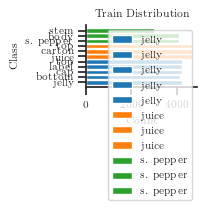

Saving fig: /data/gregork/workspace/robot-simulation/out/dataset/ts4/class_dist_validation


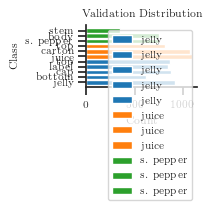

Saving fig: /data/gregork/workspace/robot-simulation/out/dataset/ts4/class_dist_test


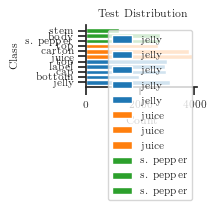

In [68]:
# Plot
to_defaults()
params = get_params("pdf", 103.50105, "pt", ar="hd", f="lm", fs=8, ff="serif", show_dpi=100, flip=False)
set_style("notebook", "ticks", params)

def add_height_text(ax, ):
    clr = "white"
    for patch in ax.patches:
        w = patch.get_width()
        h = patch.get_height()
        x,y = patch.get_xy()
        if h > 0.0:
            ax.annotate(rf"\textbf{{ {{{h:.2f}}} }}", xy=(x+w/2, h), xytext=(0,-5), textcoords="offset points", ha="center", va="center", color=clr, clip_on=True, fontsize="xx-small")


data = {"train": dftrain, "validation": dfval, "test": dftest}
ccolors = cycler(color=colors)
clrs = {supercat:clr["color"] for supercat, clr in zip(dftrain["supercat"].unique(), ccolors)}
for mode, df in data.items():
    xs = np.arange(len(df))
    width = 0.9

    fig = plt.figure()
    ax = plt.gca()
    #ax = sns.barplot(x="counts", y="cat", data=df, orient="h", ax=plt.gca())
    #df.plot(x="cat", kind="barh", ax=plt.gca())
    cats = []
    for (idx, row), x in zip(df.iterrows(), xs):
        ax.barh(x, row["counts"], width, label=row["supercat"], color=clrs[row["supercat"]])
        cats.append(row["cat"])
    ax.set_yticks(xs)
    ax.set_yticklabels(cats)

    ax.legend()
    plt.title(title_case(f"{mode} distribution"))
    plt.xlabel("Count")
    plt.ylabel("Class")
    #add_height_text(plt.gca())
    sns.despine()
    save_fig(fig, Path(cfg.OUTPUT.PATH) / f"class_dist_{mode}")
    plt.show()

## Object size 

In [18]:
data = dict() # {"train":{"cat":[], "area":[]}, "test":...}
for ttv, ttv_val in cocos.items():
    data[ttv] = {"catid":[], "cat":[], "supercat":[], "area":[], "ar":[]}
    coco_gt = ttv_val["wholes"]
    coco_dt = ttv_val["parts"]

    cat_ids = [17, 18, 19, 20, 21, 22, 23, 24, 31, 32, 33]
    gt_ann_ids = coco_gt.getAnnIds(catIds=cat_ids)
    gt_ann_infos = coco_gt.loadAnns(gt_ann_ids)
    dt_ann_ids = coco_dt.getAnnIds(catIds=cat_ids)
    dt_ann_infos = coco_dt.loadAnns(dt_ann_ids)

    for gt_ann_info in gt_ann_infos:
        cat_id = gt_ann_info["category_id"]
        area = gt_ann_info["area"]
        bbox = gt_ann_info["bbox"]

        if ttv == "train" and gt_ann_info["is_occluded"] is not None and gt_ann_info["is_occluded"]:
            continue
        else:
            if gt_ann_info["occluders"] is not None:
                assert len(gt_ann_info["occluders"]) == 0
        
            if is_whole(coco_gt, cat_id):
                cat_name = get_cat_name(coco_gt, cat_id)
                supercat_name = coco_gt.loadCats([cat_id])[0]["supercategory"]
                cat_name = tex_escape(cat_name)
                ar = bbox[2]/bbox[3]
                data[ttv]["catid"].append(cat_id)
                data[ttv]["cat"].append(cat_name)
                data[ttv]["supercat"].append(tex_escape(supercat_name))
                data[ttv]["area"].append(area)
                data[ttv]["ar"].append(ar)

    for dt_ann_info in dt_ann_infos:
        cat_id = dt_ann_info["category_id"]
        area = dt_ann_info["area"]
        bbox = dt_ann_info["bbox"]

        if ttv == "train" and dt_ann_info["is_occluded"] is not None and dt_ann_info["is_occluded"]:
            continue
        else:
            if dt_ann_info["occluders"] is not None:
                assert len(dt_ann_info["occluders"]) == 0

            if not is_whole(coco_dt, cat_id):
                cat_name = get_cat_name(coco_dt, cat_id)
                supercat_name = coco_dt.loadCats([cat_id])[0]["supercategory"]
                cat_name = tex_escape(cat_name)
                ar = bbox[2]/bbox[3]
                data[ttv]["catid"].append(cat_id)
                data[ttv]["cat"].append(cat_name)
                data[ttv]["supercat"].append(tex_escape(supercat_name))
                data[ttv]["area"].append(area)
                data[ttv]["ar"].append(ar)
dftrain = pd.DataFrame.from_dict(data["train"])
dfval = pd.DataFrame.from_dict(data["val"])
dftest = pd.DataFrame.from_dict(data["test"])


# add info which area not selected
dftrain["selected"] = dftrain["area"].apply(lambda x: x>= 100)

# Sort by supercategories
dftrain = dftrain.sort_values(["catid"])

In [19]:
to_defaults()
params = get_params("pdf", 3.25, dpi=600)
set_style("paper", "darkgrid", params)

plt.figure()
g = sns.displot(dftrain, x="area", hue="selected", log_scale=True, stat="probability")
g.legend.set_title("Selected")
#sns.li
plt.title("Overall Area Distribution over Train Images")
plt.xlabel("Area")
plt.ylabel("Relative Frequency")
#plt.xlim([0,1000])
#plt.xlim([6e4,1e5])
savefig(plt.gcf(), Path(cfg.OUTPUT.PATH) / "all_area_dist_train")
plt.show()

"""
plt.figure()
sns.displot(dfval, x="area", log_scale=True, stat="probability")
plt.title("Overall Area Distribution over Validation Images")
plt.xlabel("Area")
plt.ylabel("Relative Frequency")
savefig(plt.gcf(), Path(cfg.OUTPUT.PATH) / "all_area_dist_val")
plt.show()

plt.figure()
sns.displot(dftest, x="area", log_scale=True, stat="probability")
plt.title("Overall Area Distribution over Test Images")
plt.xlabel("Area")
plt.ylabel("Relative Frequency")
savefig(plt.gcf(), Path(cfg.OUTPUT.PATH) / "all_area_dist_test")
plt.show()
"""

TypeError: get_params() got an unexpected keyword argument 'dpi'

<Figure size 325x200.861 with 0 Axes>

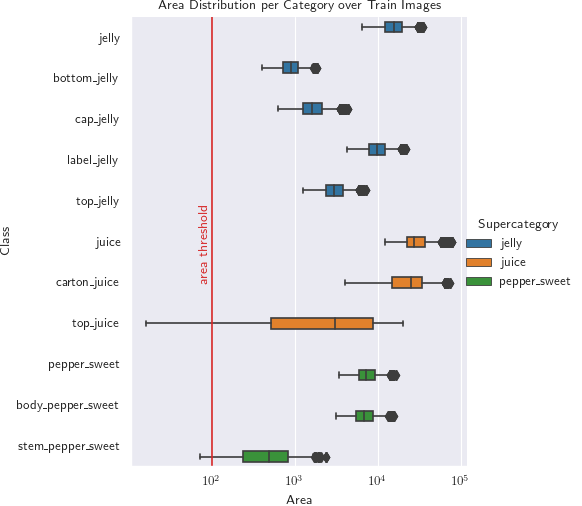

In [18]:
to_defaults()
params = get_params("pdf", 3.25, dpi=600)
set_style("paper", "darkgrid", params)

plt.figure()
g = sns.catplot(x="area", y="cat", hue="supercat", data=dftrain, kind="box")

# Add vertical area threshold line
plt.axvline(x=100, color=colors[3])
ax = plt.gca()
ax.text(100-20,6, "area threshold", color=colors[3], ha="center", rotation="vertical")

g.set(xscale="log")
g.legend.set_title("Supercategory")
plt.title("Area Distribution per Category over Train Images")
plt.xlabel("Area")
plt.ylabel("Class")
#plt.xlim([0,1000])
savefig(plt.gcf(), Path(cfg.OUTPUT.PATH) / "area_boxplot_train")
plt.show()

## Aspect ratio

<Figure size 325x200.861 with 0 Axes>

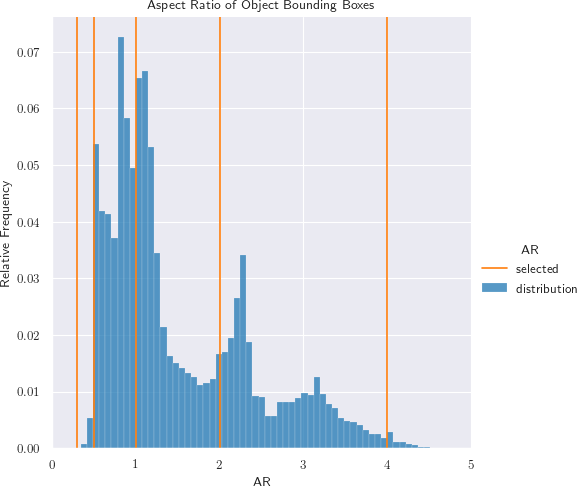

In [19]:
to_defaults()
params = get_params("pdf", 3.25, dpi=600)
set_style("paper", "darkgrid", params)

ars = [0.3,0.5,1.0,2.0,4.0]
handles, labels = [], []
plt.figure()
g = sns.displot(dftrain, x="ar", stat="probability", label="distribution")

# Create vertical lines for each selected ar and create
# handle and label for the first vertical line only
for i, ar in enumerate(ars):
    plt.axvline(ar, color=colors[1], label="selected")
    if i == 0:
        handles, labels = plt.gca().get_legend_handles_labels()

plt.legend(handles, labels, bbox_to_anchor=(1,0.5),frameon=False, fancybox=False, title="AR", )
plt.title("Aspect Ratio of Object Bounding Boxes")
plt.xlabel("AR")
plt.ylabel("Relative Frequency")
plt.xlim([0,5])
savefig(plt.gcf(), Path(cfg.OUTPUT.PATH) / "ar_train")
plt.show()

## NUmber of objects on an image

In [20]:
for ttv, ttv_val in cocos.items():
    coco_gt = ttv_val["wholes"]
    coco_dt = ttv_val["parts"]

    cat_ids = [17, 18, 19, 20, 21, 22, 23, 24, 31, 32, 33]
    gt_img_ids = extract_imgids(coco_gt, cat_ids)
    dt_img_ids = extract_imgids(coco_dt, cat_ids)

    counts = []
    for img_id in gt_img_ids:
        count = len(coco_gt.getAnnIds(imgIds=[img_id], catIds=cat_ids))
        counts.append(count)

    print(f"Min wholes count for {ttv}: {np.min(counts)}")
    print(f"Max wholes count for {ttv}: {np.max(counts)}")

    counts = []
    for img_id in dt_img_ids:
        count = len(coco_dt.getAnnIds(imgIds=[img_id], catIds=cat_ids))
        counts.append(count)

    print(f"Min parts count for {ttv}: {np.min(counts)}")
    print(f"Max parts count for {ttv}: {np.max(counts)}")

Min wholes count for train: 1
Max wholes count for train: 4
Min parts count for train: 1
Max parts count for train: 12
Min wholes count for test: 1
Max wholes count for test: 8
Min parts count for test: 1
Max parts count for test: 27
Min wholes count for val: 1
Max wholes count for val: 10
Min parts count for val: 1
Max parts count for val: 26


In [21]:
cocos

defaultdict(dict,
            {'train': {'wholes': <pycocotools.coco.COCO at 0x7fccb3eca990>,
              'parts': <pycocotools.coco.COCO at 0x7fcc6349d410>},
             'test': {'wholes': <pycocotools.coco.COCO at 0x7fcc56916e90>,
              'parts': <pycocotools.coco.COCO at 0x7fcc6349d550>},
             'val': {'wholes': <pycocotools.coco.COCO at 0x7fcc3d98e790>,
              'parts': <pycocotools.coco.COCO at 0x7fcb549d70d0>}})

## Min object IOU

In [17]:
for ttv, ttv_val in cocos.items():
    coco_gt = ttv_val["wholes"]
    coco_dt = ttv_val["parts"]

    # Get catids and imgids
    catids = [17, 18, 19, 20, 21, 22, 23, 24, 31, 32, 33]
    imgids = extract_imgids(coco_gt, catids)
    arearng = [100, np.inf]

    # For each dt annotation find corresponding gt annotation
    # Then calcuate the area
    # Average the areas between whole categories
    # Get min area
    areas = defaultdict(list)
    for imgid in imgids:
        # Get annids
        gt_annids = coco_gt.getAnnIds([imgid], catids, arearng)
        gt_anns = coco_gt.loadAnns(gt_annids)
        dt_annids = coco_dt.getAnnIds([imgid], catids, arearng) 
        dt_anns = coco_dt.loadAnns(dt_annids)

        # Filter by occlusion
        gt_anns = [gt_ann for gt_ann in gt_anns if not gt_ann["is_occluded"]]
        dt_anns = [dt_ann for dt_ann in dt_anns if not dt_ann["is_occluded"]]

        for dt_ann in dt_anns:
            corr_gt_anns = [gt_ann for gt_ann in gt_anns if gt_ann["spawn_id"] == dt_ann["spawn_id"]]
            if corr_gt_anns:
                assert len(corr_gt_anns) == 1
                catid = corr_gt_anns[0]["category_id"]
                dt_area = dt_ann["area"]
                gt_area = corr_gt_anns[0]["area"]
                areas[catid].append(dt_area/gt_area)

    

    averages = []
    for catid, vals in areas.items():
        averages.append(np.min(vals))

    print(ttv)
    print(min(averages))
    



train
0.0033678280570693772
test
0.003417984347548315
val
0.005439409705798884
